# <font color='Blue'>📦 Projeto: Modelagem do Tempo Total de Entrega</font>
<hr style='border: 2px solid Blue;'>

# <font color='orange' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid orange;'>

In [74]:
## Bibliotecas Gerais 
import sys
sys.executable
import re

## Bibliotecas de Análise de Dados
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random


# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import shap

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score

# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

# <font color='orange' style='font-size: 40px;'> Functions </font>
<hr style='border: 2px solid orange;'>

In [75]:
def plota_barras(variaveis, df, titulo_base='Distribuição', rotation=0,
                 figsize=(8, 5), top_n=None, limites=None, usar_subplot=False):

    # --- Normalização de entrada ---
    if isinstance(variaveis, str):
        variaveis = [variaveis]
    if limites is None:
        limites = {}

    # ============================================================
    # FUNÇÃO AUXILIAR: ordena apenas se valores forem numéricos
    # ============================================================
    def ordenar_counts_se_numerico(counts):
        try:
            # tenta converter todos os labels para número
            pd.to_numeric(counts.index, errors='raise')
            return counts.sort_index()      # ordena se der certo
        except:
            return counts                   # mantém a ordem original

    # ============================================================
    # CASO 1: Uma variável ou subplot desativado
    # ============================================================
    if len(variaveis) == 1 or not usar_subplot:
        for var in variaveis:

            limite_var = limites.get(var, top_n)
            counts = df[var].value_counts()

            # Ordenação segura
            counts = ordenar_counts_se_numerico(counts)

            if limite_var is not None:
                counts = counts.head(limite_var)

            order = counts.index
            values = counts.values
            total = values.sum()

            plt.figure(figsize=figsize)
            ax = sns.barplot(x=order, y=values, color='#1FB3E5')
            ax.set_title(f'{titulo_base} — {var}', fontsize=14)
            ax.set_xlabel(var, fontsize=12)
            ax.set_ylabel('Quantidade', fontsize=12)

            # Percentuais acima das barras
            for i, v in enumerate(values):
                ax.text(i, v + (max(values) * 0.01), f'{(v/total)*100:.2f}%',
                        ha='center', va='bottom', fontsize=10)

            ax.set_ylim(0, max(values) * 1.15)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
            ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

            plt.tight_layout()
            plt.show()
        return

    # ============================================================
    # CASO 2: Múltiplas variáveis com subplot
    # ============================================================
    n_vars = len(variaveis)
    n_cols = 2
    n_rows = (n_vars + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    axes = axes.flatten()

    for i, var in enumerate(variaveis):

        limite_var = limites.get(var, top_n)
        counts = df[var].value_counts()

        # Ordenação segura
        counts = ordenar_counts_se_numerico(counts)

        if limite_var is not None:
            counts = counts.head(limite_var)

        order = counts.index
        values = counts.values
        total = values.sum()

        ax = axes[i]
        sns.barplot(x=order, y=values, color='#1FB3E5', ax=ax)
        ax.set_title(f'{var}', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Qtd')

        for j, v in enumerate(values):
            ax.text(j, v + (max(values) * 0.01), f'{(v/total)*100:.1f}%',
                    ha='center', va='bottom', fontsize=9)

        ax.set_ylim(0, max(values) * 1.15)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=9)

    # Remove subplots vazios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(titulo_base, fontsize=16)
    plt.tight_layout()
    plt.show()




def plota_boxplot(df,variaveis,target=None,titulo_base='Boxplot',rotation=0,figsize=(8, 5),usar_subplot=False,modo='bivariado'):

    if isinstance(variaveis, str):
        variaveis = [variaveis]

    # --- Caso simples (um gráfico por variável) ---
    if len(variaveis) == 1 or not usar_subplot:
        for var in variaveis:
            plt.figure(figsize=figsize)

            if modo == 'bivariado':
                if target is None:
                    raise ValueError("No modo 'bivariado', o parâmetro 'target' é obrigatório.")
                sns.boxplot(x=target, y=var, data=df, palette=['green', 'yellow', 'red'])
                plt.xlabel(target)
            else:  # univariado
                sns.boxplot(y=var, data=df, color='#1FB3E5')

            plt.title(f'{titulo_base} — {var}', fontsize=12)
            plt.ylabel(var)
            plt.xticks(rotation=rotation)
            plt.tight_layout()
            plt.show()
        return

    # --- Caso com subplots (várias variáveis) ---
    n_vars = len(variaveis)
    n_cols = 2
    n_rows = (n_vars + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    axes = axes.flatten()

    for i, var in enumerate(variaveis):
        ax = axes[i]

        if modo == 'bivariado':
            if target is None:
                raise ValueError("No modo 'bivariado', o parâmetro 'target' é obrigatório.")
            sns.boxplot(x=target, y=var, data=df, ax=ax, palette=['green', 'yellow', 'red'])
            ax.set_xlabel(target)
        else:
            sns.boxplot(y=var, data=df, ax=ax, color='#1FB3E5')

        ax.set_title(f'{var}', fontsize=11)
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=rotation)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(titulo_base, fontsize=14)
    plt.tight_layout()
    plt.show()



def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(20, 8))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(20, 8))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        #plt.ylim(0, 50)
        plt.tight_layout()
        plt.show()


# <font color='orange' style='font-size: 40px;'> 1. Leitura do Dataset </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/datasets/nosbielcs/brazilian-delivery-center?resource=download

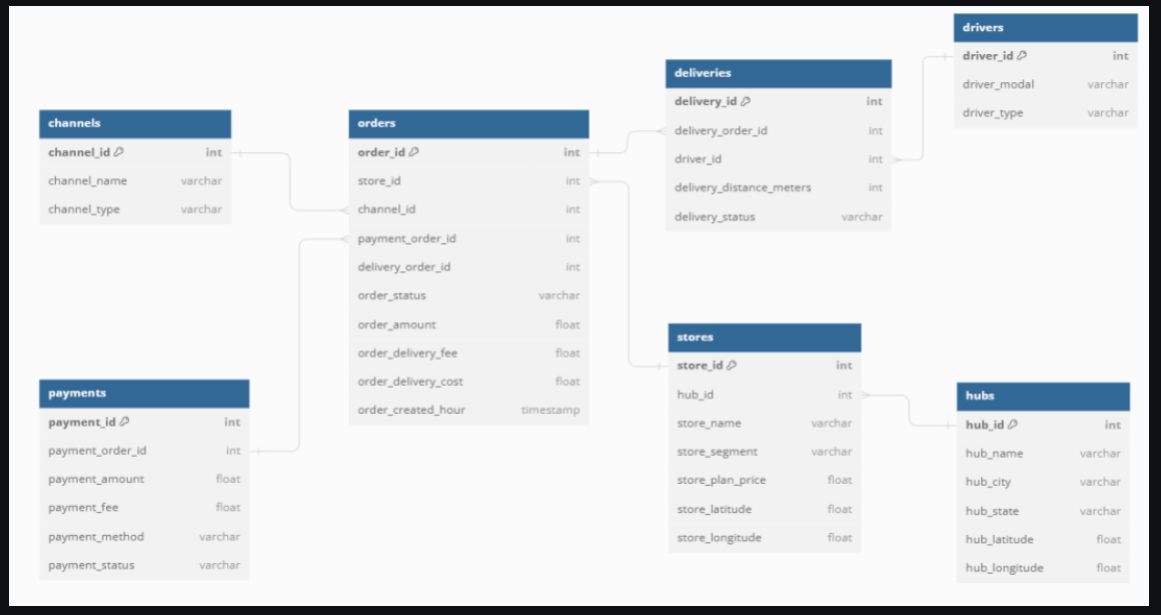


## 1.1.1) Channels

> 1. Este dataset possui informações sobre os canais de venda (marketplaces) onde são vendidos os good e food de nossos lojistas.

- **Channel ID:** Identificador único do canal de vendas.
- **Channel Name:** Nome do canal de vendas.
- **Channel Type:** Tipo de canal de vendas.

## 1.1.2) Deliveries

> 1. Este dataset possui informações sobre as entregas realizadas por nossos entregadores parceiros.

- **Delivery Id:** Identificador único da entrega.
- **Delivery Order ID:** Identificador único do pedido.
- **Driver Id:** Identificador do entregador responsável pela entrega.
- **Delivery Distance Meters:** Distância total percorrida para a entrega, em metros.
- **Delivery Status:** Status atual da entrega.

## 1.1.3) Drivers

> 1. Este dataset possui informações sobre os entregadores parceiros. Eles ficam em nossos hubs e toda vez que um pedido é processado, são eles fazem as entregas na casa dos consumidores.

- **Driver Id:** Identificador único do entregador.
- **Driver Modal:** Modalidade de transporte utilizada pelo entregador.
- **Driver Type:** Tipo de entregador.

## 1.1.4) Hubs

> 1. Este dataset possui informações sobre os hubs do Delivery Center. Entenda que os Hubs são os centros de distribuição dos pedidos e é dali que saem as entregas.

- **Hub ID:** Identificador único do hub.
- **Hub Name:** Nome do hub.
- **Hub City:** Cidade onde o hub está localizado.
- **Hub State:** Estado onde o hub está localizado.
- **Hub Latitude:** Latitude da localização do hub.
- **Hub Longitude:** Longitude da localização do hub.

## 1.1.5) Orders

> 1. Este dataset possui informações sobre as vendas processadas através da plataforma do Delivery Center.

- **Delivery Order ID:** Identificador único do pedido.
- **Store ID:** Identificador da loja que recebeu o pedido.
- **Channel ID:** Identificador do canal pelo qual o pedido foi realizado.
- **Order Status:** Status atual do pedido.
- **Order Amount:** Valor total do pedido.
- **Order Delivery Fee:** Taxa de entrega cobrada ao cliente.
- **Order Delivery Cost:** Custo da entrega para a plataforma ou loja.
- **Order Created Hour:** Hora em que o pedido foi criado.
- **Order Created Minute:** Minuto em que o pedido foi criado.
- **Order Created Day:** Dia em que o pedido foi criado.
- **Order Created Month:** Mês em que o pedido foi criado.
- **Order Created Year:** Ano em que o pedido foi criado.
- **Order Moment Created:** Momento exato em que o pedido foi criado.
- **Order Moment Accepted:** Momento em que o pedido foi aceito pela loja.
- **Order Moment Ready:** Momento em que o pedido ficou pronto para entrega.
- **Order Moment Collected:** Momento em que o pedido foi coletado pelo entregador.
- **Order Moment In Expedition:** Momento em que o pedido entrou em expedição.
- **Order Moment Delivering:** Momento em que o pedido está sendo entregue.
- **Order Moment Delivered:** Momento em que o pedido foi entregue ao cliente.
- **Order Moment Finished:** Momento em que o pedido foi finalizado no sistema.

## 1.1.6) Payments

> 1. Este dataset possui informações sobre os pagamentos realizados ao Delivery Center.

- **Payment ID:** Identificador único do pagamento.
- **Delivery Order ID:** Identificador único do pedido.
- **Payment Amount:** Valor total pago pelo cliente.
- **Payment Fee:** Taxa de processamento do pagamento.
- **Payment Method:** Método de pagamento utilizado pelo cliente.
- **Payment Status:** Status atual do pagamento.

## 1.1.7) Stores

> 1. Este dataset possui informações sobre os lojistas. Eles utilizam a Plataforma do Delivery Center para vender seus itens (good e/ou food) nos marketplaces.

- **Store ID:** Identificador único da loja.
- **Hub ID:** Identificador do hub ao qual a loja está associada.
- **Store Name:** Nome da loja.
- **Store Segment:** Segmento ou categoria da loja.
- **Store Plan Price:** Preço do plano de assinatura da loja na plataforma.
- **Store Latitude:** Latitude da localização da loja.
- **Store Longitude:** Longitude da localização da loja.


In [76]:
df_orders = (
    pd.read_csv('../Modelo_Delivery/data/orders.csv')
    .drop(['order_id', 'payment_order_id'], axis = 1)
    .rename(
        {
            'delivery_order_id':'delivery_order_id',
            'channel_id':'channel_id',
            'store_id':'store_id',
        },
        axis = 1
    )
)
df_channels = pd.read_csv('../Modelo_Delivery/data/channels.csv')
df_deliveries = pd.read_csv('../Modelo_Delivery/data/deliveries.csv')
df_drivers = pd.read_csv('../Modelo_Delivery/data/drivers.csv')
df_hubs = pd.read_csv('../Modelo_Delivery/data/hubs.csv', encoding='latin-1')
df_payments = pd.read_csv('../Modelo_Delivery/data/payments.csv').rename({'payment_order_id':'delivery_order_id'}, axis=1)
df_stores = pd.read_csv('../Modelo_Delivery/data/stores.csv', encoding='latin-1')

In [77]:
colunas_renomeadas = {
    # ------------------- ORDERS -------------------
    'store_id': 'id_loja',
    'channel_id': 'id_canal',
    'delivery_order_id': 'id_pedido_entrega',
    'order_status': 'status_pedido',
    'order_amount': 'valor_pedido',
    'order_delivery_fee': 'taxa_entrega_cliente',
    'order_delivery_cost': 'custo_entrega_plataforma',
    'order_created_hour': 'hora_criacao_pedido',
    'order_created_minute': 'minuto_criacao_pedido',
    'order_created_day': 'dia_criacao_pedido',
    'order_created_month': 'mes_criacao_pedido',
    'order_created_year': 'ano_criacao_pedido',
    'order_moment_created': 'momento_criacao_pedido',
    'order_moment_accepted': 'momento_aceite_pedido',
    'order_moment_ready': 'momento_pedido_pronto',
    'order_moment_collected': 'momento_pedido_coletado',
    'order_moment_in_expedition': 'momento_pedido_expedicao',
    'order_moment_delivering': 'momento_pedido_em_entrega',
    'order_moment_delivered': 'momento_pedido_entregue',
    'order_moment_finished': 'momento_pedido_finalizado',

    # Métricas de tempo do pedido
    'order_metric_collected_time': 'tempo_coleta_pedido',
    'order_metric_paused_time': 'tempo_pedido_pausado',
    'order_metric_production_time': 'tempo_producao_pedido',
    'order_metric_walking_time': 'tempo_deslocamento_pedido',
    'order_metric_expediton_speed_time': 'tempo_expedicao_pedido',
    'order_metric_transit_time': 'tempo_transito_pedido',
    'order_metric_cycle_time': 'tempo_ciclo_pedido',

    # ------------------- CHANNELS -------------------
    'channel_name': 'nome_canal',
    'channel_type': 'tipo_canal',

    # ------------------- PAYMENTS -------------------
    'payment_id': 'id_pagamento',
    'payment_amount': 'valor_pagamento',
    'payment_fee': 'taxa_pagamento',
    'payment_method': 'metodo_pagamento',
    'payment_status': 'status_pagamento',

    # ------------------- DELIVERIES -------------------
    'delivery_id': 'id_entrega',
    'driver_id': 'id_entregador',
    'delivery_distance_meters': 'distancia_entrega_metros',
    'delivery_status': 'status_entrega',

    # ------------------- STORES -------------------
    'store_name': 'nome_loja',
    'store_segment': 'segmento_loja',
    'store_plan_price': 'preco_plano_loja',
    'store_latitude': 'latitude_loja',
    'store_longitude': 'longitude_loja',

    # ------------------- DRIVERS -------------------
    'driver_modal': 'modal_entregador',
    'driver_type': 'tipo_entregador',

    # ------------------- HUBS -------------------
    'hub_id': 'id_hub',
    'hub_name': 'nome_hub',
    'hub_city': 'cidade_hub',
    'hub_state': 'estado_hub',
    'hub_latitude': 'latitude_hub',
    'hub_longitude': 'longitude_hub',
}


df_full = (
    df_orders
    .merge(df_channels, on='channel_id', how='left') # Merge OK
    .merge(df_payments, on='delivery_order_id', how='left') # Merge Ok
    .merge(df_deliveries, on='delivery_order_id', how='left')
    .merge(df_stores, on='store_id', how='left')
    .merge(df_drivers, on='driver_id', how='left')
    .merge(df_hubs, on='hub_id', how='left')
)

df_full.rename(columns=colunas_renomeadas, inplace=True)

display(df_full.shape)
df_full.head()

(442239, 51)

,id_loja,id_canal,id_pedido_entrega,status_pedido,valor_pedido,taxa_entrega_cliente,custo_entrega_plataforma,hora_criacao_pedido,minuto_criacao_pedido,dia_criacao_pedido,mes_criacao_pedido,ano_criacao_pedido,momento_criacao_pedido,momento_aceite_pedido,momento_pedido_pronto,momento_pedido_coletado,momento_pedido_expedicao,momento_pedido_em_entrega,momento_pedido_entregue,momento_pedido_finalizado,tempo_coleta_pedido,tempo_pedido_pausado,tempo_producao_pedido,tempo_deslocamento_pedido,tempo_expedicao_pedido,tempo_transito_pedido,tempo_ciclo_pedido,nome_canal,tipo_canal,id_pagamento,valor_pagamento,taxa_pagamento,metodo_pagamento,status_pagamento,id_entrega,id_entregador,distancia_entrega_metros,status_entrega,id_hub,nome_loja,segmento_loja,preco_plano_loja,latitude_loja,longitude_loja,modal_entregador,tipo_entregador,nome_hub,cidade_hub,estado_hub,latitude_hub,longitude_hub
0,3512,5,68405119,CANCELED,62.70,0.00,NaN,0,1,1,1,2021,1/1/2021 12:01:36 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,GOI SIPIMUSU,FOOD,49.00,-25.48,-49.29,NaN,NaN,PYTHON SHOPPING,CURITIBA,PR,-25.48,-49.29
1,3512,5,68405123,CANCELED,62.70,0.00,NaN,0,4,1,1,2021,1/1/2021 12:04:26 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,GOI SIPIMUSU,FOOD,49.00,-25.48,-49.29,NaN,NaN,PYTHON SHOPPING,CURITIBA,PR,-25.48,-49.29
2,3512,5,68405206,CANCELED,115.50,0.00,NaN,0,13,1,1,2021,1/1/2021 12:13:07 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,GOI SIPIMUSU,FOOD,49.00,-25.48,-49.29,NaN,NaN,PYTHON SHOPPING,CURITIBA,PR,-25.48,-49.29
3,3401,5,68405465,CANCELED,55.90,0.00,NaN,0,19,1,1,2021,1/1/2021 12:19:15 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,FRUEOU,FOOD,49.90,-25.44,-49.28,NaN,NaN,HOTMILK SHOPPING,CURITIBA,PR,-25.44,-49.28
4,3401,5,68406064,CANCELED,37.90,0.00,NaN,0,26,1,1,2021,1/1/2021 12:26:25 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,FRUEOU,FOOD,49.90,-25.44,-49.28,NaN,NaN,HOTMILK SHOPPING,CURITIBA,PR,-25.44,-49.28


# <font color='orange' style='font-size: 40px;'> 2. Análise Exploratória - Entendimento das Variáveis </font>
<hr style='border: 2px solid orange;'>

> **Objetivo:** Entender as características das tabelas (Orders, Deliveries, Stores, Drivers, Hubs, Channels, Payments) e como elas se relacionam entre si.

### 2.1) Entendimento das Bases

- Dimensão de cada tabela (linhas x colunas)
- Tipos de variáveis e % de valores nulos
- Identificação das chaves primárias e estrangeiras
- Compreensão do fluxo do processo logístico:
  - Criação do pedido
  - Aceite pela loja
  - Coleta pelo entregador
  - Expedição e entrega

### 2.2) Estatísticas Descritivas Iniciais

- Distribuição de **order_amount**, **delivery_distance_meters**, **store_plan_price**, etc.
- Frequência de pedidos por **canal**, **cidade**, **estado** e **segmento de loja**
- Identificação de **outliers** e **valores inconsistentes**
- Análise de sazonalidade ou concentração temporal (ex: pedidos por hora/dia/mês)

In [78]:
def gera_metadados(df, colunas_renomeadas):
    """
    Gera um dicionário detalhado de variáveis baseado no DataFrame e no mapeamento das colunas.
    Inclui descrições oficiais de negócio conforme documentação do Delivery Center.
    """
    
    # ===================== 1) DICIONÁRIO DE DESCRIÇÕES POR BASE =====================
    descricoes = {
        # ---------- CHANNELS ----------
        'Base Channels': {
            'channel_id': 'Identificador único do canal de vendas.',
            'channel_name': 'Nome do canal de vendas.',
            'channel_type': 'Tipo de canal de vendas.'
        },
        # ---------- DELIVERIES ----------
        'Base Deliveries': {
            'delivery_id': 'Identificador único da entrega.',
            'delivery_order_id': 'Identificador único do pedido.',
            'driver_id': 'Identificador do entregador responsável pela entrega.',
            'delivery_distance_meters': 'Distância total percorrida para a entrega, em metros.',
            'delivery_status': 'Status atual da entrega.'
        },
        # ---------- DRIVERS ----------
        'Base Drivers': {
            'driver_id': 'Identificador único do entregador.',
            'driver_modal': 'Modalidade de transporte utilizada pelo entregador.',
            'driver_type': 'Tipo de entregador.'
        },
        # ---------- HUBS ----------
        'Base Hubs': {
            'hub_id': 'Identificador único do hub.',
            'hub_name': 'Nome do hub.',
            'hub_city': 'Cidade onde o hub está localizado.',
            'hub_state': 'Estado onde o hub está localizado.',
            'hub_latitude': 'Latitude da localização do hub.',
            'hub_longitude': 'Longitude da localização do hub.'
        },
        # ---------- ORDERS ----------
        'Base Orders': {
            'delivery_order_id': 'Identificador único do pedido.',
            'store_id': 'Identificador da loja que recebeu o pedido.',
            'channel_id': 'Identificador do canal pelo qual o pedido foi realizado.',
            'order_status': 'Status atual do pedido.',
            'order_amount': 'Valor total do pedido.',
            'order_delivery_fee': 'Taxa de entrega cobrada ao cliente.',
            'order_delivery_cost': 'Custo da entrega para a plataforma ou loja.',
            'order_created_hour': 'Hora em que o pedido foi criado.',
            'order_created_minute': 'Minuto em que o pedido foi criado.',
            'order_created_day': 'Dia em que o pedido foi criado.',
            'order_created_month': 'Mês em que o pedido foi criado.',
            'order_created_year': 'Ano em que o pedido foi criado.',
            'order_moment_created': 'Momento exato em que o pedido foi criado.',
            'order_moment_accepted': 'Momento em que o pedido foi aceito pela loja.',
            'order_moment_ready': 'Momento em que o pedido ficou pronto para entrega.',
            'order_moment_collected': 'Momento em que o pedido foi coletado pelo entregador.',
            'order_moment_in_expedition': 'Momento em que o pedido entrou em expedição.',
            'order_moment_delivering': 'Momento em que o pedido está sendo entregue.',
            'order_moment_delivered': 'Momento em que o pedido foi entregue ao cliente.',
            'order_moment_finished': 'Momento em que o pedido foi finalizado no sistema.',
            'order_metric_collected_time': 'Tempo até o pedido ser coletado.',
            'order_metric_paused_time': 'Tempo que o pedido ficou pausado.',
            'order_metric_production_time': 'Tempo de produção do pedido.',
            'order_metric_walking_time': 'Tempo de deslocamento para coleta.',
            'order_metric_expediton_speed_time': 'Tempo de expedição do pedido.',
            'order_metric_transit_time': 'Tempo de trânsito até o cliente.',
            'order_metric_cycle_time': 'Tempo total do ciclo do pedido.'
        },
        # ---------- PAYMENTS ----------
        'Base Payments': {
            'payment_id': 'Identificador único do pagamento.',
            'delivery_order_id': 'Identificador único do pedido.',
            'payment_amount': 'Valor total pago pelo cliente.',
            'payment_fee': 'Taxa de processamento do pagamento.',
            'payment_method': 'Método de pagamento utilizado pelo cliente.',
            'payment_status': 'Status atual do pagamento.'
        },
        # ---------- STORES ----------
        'Base Stores': {
            'store_id': 'Identificador único da loja.',
            'hub_id': 'Identificador do hub ao qual a loja está associada.',
            'store_name': 'Nome da loja.',
            'store_segment': 'Segmento ou categoria da loja.',
            'store_plan_price': 'Preço do plano de assinatura da loja na plataforma.',
            'store_latitude': 'Latitude da localização da loja.',
            'store_longitude': 'Longitude da localização da loja.'
        }
    }
    
    # ===================== 2) FUNÇÃO AUXILIAR PARA INFERIR BASE =====================
    def inferir_base(nome_original):
        if 'order' in nome_original:
            return 'Base Orders'
        elif 'payment' in nome_original:
            return 'Base Payments'
        elif 'store' in nome_original:
            return 'Base Stores'
        elif 'channel' in nome_original:
            return 'Base Channels'
        elif 'delivery' in nome_original:
            return 'Base Deliveries'
        elif 'driver' in nome_original:
            return 'Base Drivers'
        elif 'hub' in nome_original:
            return 'Base Hubs'
        else:
            return 'Base Desconhecida'

    # ===================== 3) CONSTRUÇÃO DA TABELA =====================
    registros = []
    for col_original, col_nova in colunas_renomeadas.items():
        if col_nova not in df.columns:
            continue
        base = inferir_base(col_original)
        qtd_distintos = df[col_nova].nunique(dropna=True)
        tipo = str(df[col_nova].dtype)
        descricao = descricoes.get(base, {}).get(col_original, 'Descrição não encontrada.')
        registros.append({
            'variavel': col_nova,
            'quantidade_valores_distintos': qtd_distintos,
            'tipagem': tipo,
            'base': base,
            'descricao': descricao
        })
    
    return pd.DataFrame(registros)

def classificar_variaveis_entregas_df(df_meta):
    """
    Classifica as variáveis do projeto de modelagem de tempo de entrega
    e retorna um DataFrame com a estrutura:

    VARIÁVEL_CATEGÓRICA | VARIÁVEL_DISCRETA | VARIÁVEL_CONTÍNUA | VARIÁVEL_TEMPORAL | VARIÁVEL_CHAVE_IDENTIFICADORA
    ---------------------------------------------------------------------------------------------------------------
    var1                | varA              | varX              | varY              | varZ
    var2                | varB              | varW              | ...               | ...
    ...
    """

    def categorizar(linha):
        nome = linha['variavel'].lower()
        desc = str(linha['descricao']).lower()
        tipo = str(linha['tipagem']).lower()
        qtd = linha['quantidade_valores_distintos']

        # Identificadores
        if any(p in nome for p in ['id_', 'identificador']) or 'identificador' in desc:
            return 'chave / identificador'
        
        # Financeiras ou medidas
        if any(p in nome for p in ['valor', 'taxa', 'preco', 'custo', 'distancia', 'plano']) or \
           any(p in desc for p in ['valor', 'preço', 'taxa', 'custo', 'distância', 'plano']):
            return 'contínua'

        # Temporais
        if any(p in nome for p in ['data', 'momento', 'tempo', 'hora', 'minuto', 'dia', 'mes', 'ano']) or \
           any(p in desc for p in ['momento', 'tempo', 'hora', 'minuto', 'dia', 'mês', 'ano']):
            return 'temporal'

        # Categóricas
        if 'status' in nome or 'tipo' in nome or 'metodo' in nome or \
           'segmento' in nome or 'categoria' in desc or 'nome' in nome:
            return 'categórica'

        # Binárias
        if qtd == 2:
            return 'categórica'

        # Geográficas Contínuas
        if any(p in nome for p in ['latitude', 'longitude']):
            return 'contínua'
        
        # Geográficas Categóricas
        if any(p in nome for p in ['cidade', 'estado']):
            return 'categórica'

        # Numéricas em geral
        if tipo in ['float64', 'int64']:
            if qtd > 100:
                return 'contínua'
            else:
                return 'discreta'

        # Padrão
        return 'categórica'

    # Classificar variáveis
    df_meta['categoria_variavel'] = df_meta.apply(categorizar, axis=1)

    # Agrupar por categoria
    grupos = (
        df_meta.groupby('categoria_variavel')['variavel']
        .apply(list)
        .to_dict()
    )

    # Garantir todas as categorias mesmo se vazias
    categorias = ['categórica', 'discreta', 'contínua', 'temporal', 'chave / identificador']
    for c in categorias:
        if c not in grupos:
            grupos[c] = []

    # Definir o comprimento máximo para alinhar colunas
    max_len = max(len(v) for v in grupos.values())

    # Criar o DataFrame final
    df_final = pd.DataFrame({
        'VARIÁVEIS CATEGÓRICAS': pd.Series(grupos['categórica']),
        'VARIÁVEIS DISCRETAS': pd.Series(grupos['discreta']),
        'VARIÁVEIS CONTÍNUAS': pd.Series(grupos['contínua']),
        'VARIÁVEIS TEMPORAIS': pd.Series(grupos['temporal']),
        'VARIÁVEIS CHAVE / IDENTIFICADORAS': pd.Series(grupos['chave / identificador'])
    })

    return df_final, df_meta

# <font color='green' style='font-size: 30px;'> 2.1) Metadados </font>
<hr style='border: 2px solid green;'>



In [79]:
metadados = gera_metadados(df_full, colunas_renomeadas)
display(df_full.shape)
texto_resumo, tabela_classificada = classificar_variaveis_entregas_df(metadados)
display(texto_resumo)
display(tabela_classificada.sort_values(by='base', ascending = True))


(442239, 51)

,VARIÁVEIS CATEGÓRICAS,VARIÁVEIS DISCRETAS,VARIÁVEIS CONTÍNUAS,VARIÁVEIS TEMPORAIS,VARIÁVEIS CHAVE / IDENTIFICADORAS
0,status_pedido,NaN,valor_pedido,hora_criacao_pedido,id_loja
1,nome_canal,NaN,taxa_entrega_cliente,minuto_criacao_pedido,id_canal
2,tipo_canal,NaN,custo_entrega_plataforma,dia_criacao_pedido,id_pedido_entrega
3,metodo_pagamento,NaN,valor_pagamento,mes_criacao_pedido,id_pagamento
4,status_pagamento,NaN,taxa_pagamento,ano_criacao_pedido,id_entrega
5,status_entrega,NaN,distancia_entrega_metros,momento_criacao_pedido,id_entregador
6,nome_loja,NaN,preco_plano_loja,momento_aceite_pedido,id_hub
7,segmento_loja,NaN,latitude_loja,momento_pedido_pronto,NaN
8,modal_entregador,NaN,longitude_loja,momento_pedido_coletado,NaN
9,tipo_entregador,NaN,latitude_hub,momento_pedido_expedicao,NaN


,variavel,quantidade_valores_distintos,tipagem,base,descricao,categoria_variavel
1,id_canal,39,int64,Base Channels,Identificador único do canal de vendas.,chave / identificador
27,nome_canal,39,object,Base Channels,Nome do canal de vendas.,categórica
28,tipo_canal,2,object,Base Channels,Tipo de canal de vendas.,categórica
36,distancia_entrega_metros,16477,float64,Base Deliveries,"Distância total percorrida para a entrega, em metros.",contínua
34,id_entrega,378843,float64,Base Deliveries,Identificador único da entrega.,chave / identificador
37,status_entrega,3,object,Base Deliveries,Status atual da entrega.,categórica
44,tipo_entregador,2,object,Base Drivers,Tipo de entregador.,categórica
43,modal_entregador,2,object,Base Drivers,Modalidade de transporte utilizada pelo entregador.,categórica
35,id_entregador,4583,float64,Base Drivers,Identificador único do entregador.,chave / identificador
49,latitude_hub,32,float64,Base Hubs,Latitude da localização do hub.,contínua


In [80]:
################ CATEGÓRICAS ################
categoricas = ['status_pedido', 'nome_canal', 'tipo_canal', 'metodo_pagamento',
       'status_pagamento', 'status_entrega', 'nome_loja', 'segmento_loja',
       'modal_entregador', 'tipo_entregador', 'nome_hub', 'cidade_hub',
       'estado_hub']

categoricas_grupos = {
    'Canais de Venda': ['nome_canal', 'tipo_canal'],
    'Pagamentos': ['metodo_pagamento', 'status_pagamento'],
    'Pedidos e Entregas': ['status_pedido', 'status_entrega'],
    'Lojas': ['nome_loja', 'segmento_loja'],
    'Entregadores': ['modal_entregador', 'tipo_entregador'],
    'Hubs': ['nome_hub', 'cidade_hub', 'estado_hub']
}

################ CONTÍNUAS ################
continuas = ['valor_pedido', 'taxa_entrega_cliente', 'custo_entrega_plataforma', 'preco_plano_loja',
       'valor_pagamento', 'taxa_pagamento', 'distancia_entrega_metros',
       'latitude_loja', 'longitude_loja', 'latitude_hub', 'longitude_hub']

continuas_grupos = {
    'Pedidos e Entregas': ['valor_pedido', 'taxa_entrega_cliente', 'custo_entrega_plataforma', 'distancia_entrega_metros'],
    'Pagamentos': ['valor_pagamento', 'taxa_pagamento'],
    'Lojas': ['preco_plano_loja', 'latitude_loja', 'longitude_loja'],
    'Hubs': ['latitude_hub', 'longitude_hub']
}

################ TEMPORAIS ################
temporais = ['hora_criacao_pedido', 'minuto_criacao_pedido',
       'dia_criacao_pedido', 'mes_criacao_pedido', 'ano_criacao_pedido',
       'momento_criacao_pedido', 'momento_aceite_pedido',
       'momento_pedido_pronto', 'momento_pedido_coletado',
       'momento_pedido_expedicao', 'momento_pedido_em_entrega',
       'momento_pedido_entregue', 'momento_pedido_finalizado',
       'tempo_coleta_pedido', 'tempo_pedido_pausado',
       'tempo_producao_pedido', 'tempo_deslocamento_pedido',
       'tempo_expedicao_pedido', 'tempo_transito_pedido',
       'tempo_ciclo_pedido']

temporais_grupos = {
    'Criação do Pedido': [
        'hora_criacao_pedido', 'minuto_criacao_pedido', 'dia_criacao_pedido',
        'mes_criacao_pedido', 'ano_criacao_pedido', 'momento_criacao_pedido'
    ],
    'Andamento do Pedido': [
        'momento_aceite_pedido', 'momento_pedido_pronto', 'momento_pedido_coletado',
        'momento_pedido_expedicao', 'momento_pedido_em_entrega', 'momento_pedido_entregue',
        'momento_pedido_finalizado'
    ],
    'Métricas de Tempo do Pedido': [
        'tempo_coleta_pedido', 'tempo_pedido_pausado', 'tempo_producao_pedido',
        'tempo_deslocamento_pedido', 'tempo_expedicao_pedido', 'tempo_transito_pedido',
        'tempo_ciclo_pedido'
    ]
}

################ CHAVE/IDENTIFICADORAS ################
chave_identificadoras = ['id_loja', 'id_canal', 'id_pedido_entrega', 'id_pagamento',
       'id_entrega', 'id_entregador', 'id_hub']

chave_identificadoras_grupos = {
    'Pedidos': ['id_pedido_entrega', 'id_pagamento', 'id_entrega'],
    'Lojas e Canais': ['id_loja', 'id_canal'],
    'Hubs e Entregadores': ['id_hub', 'id_entregador']
}

### TARGET = momento_pedido_finalizado - momento_aceite_pedido

In [81]:
# # Caminho de saída
# caminho_arquivo = "./metadados/classificacao_variaveis.xlsx"

# # Criar o arquivo Excel com múltiplas abas
# with pd.ExcelWriter(caminho_arquivo, engine='openpyxl') as writer:
#     texto_resumo.to_excel(writer, sheet_name='Resumo', index=False)
#     tabela_classificada.to_excel(writer, sheet_name='Classificação', index=False)

# print(f"Arquivo Excel gerado com sucesso: {caminho_arquivo}")

# <font color='green' style='font-size: 30px;'> 2.2) Análise Nulos </font>
<hr style='border: 2px solid green;'>

> 1. Muitas variáveis possuem diversos valores nulos

> 2. Na etapa de pré-processamento devemos levar isso em consideração e tratá-los de alguma forma

Existem 51 variáveis no Dataset
Existem 22 variáveis sem registros nulos no Dataset


<Figure size 800x500 with 0 Axes>

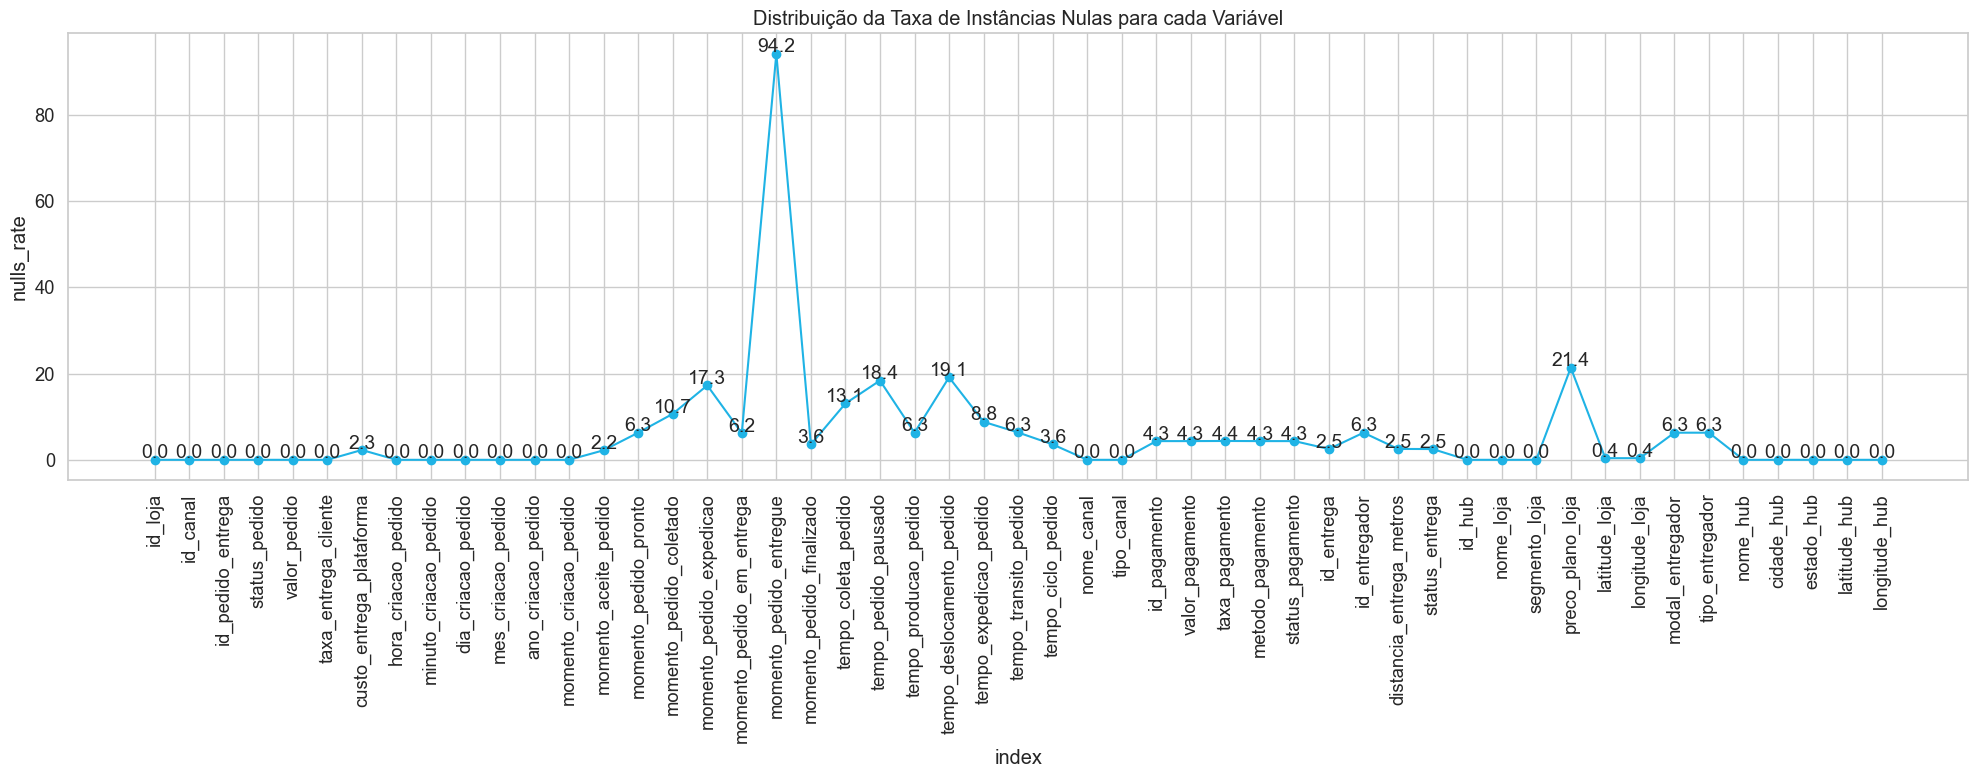

In [82]:
df_nulls = (
    pd.DataFrame(
        df_full
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_full.shape[0])*100, 2)

print(f'Existem {len(df_nulls)} variáveis no Dataset')
df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
columns_not_nulls = list(df_not_nulls_nulls['index'])
print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 2.3) Análise de Variáveis Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. Nesta etapa, o intuito foi identificar padrões macro sobre as variáveis categóricas, dentre eles:

- A maior parte está presente no Market Place (plataforma de terceiros que reúne diversos vendedores com oferecimento de infraestrutura e cobrança de comissões) em detrimento de Canal Próprio
- Praticamente todas as compras foram devidamente pagas, com pouquíssimas devoluções. Dentre os pagamentos, a grande parte foi realizada via Online, seguida de Vouchers (provavelmente fisicamente).
- A grande parte dos pedidos e das entregas foram devidamente realizados, com poucos casos de pedidos cancelados 
- A maior parte dos estabelecimentos são especializados em comida
- A maior parte dos entregadoress utilizam Motos como veículo de transporte, bem como o regime de "Autônomo" em detrimento de Bicicletas ou Operações Logísticas
- Temos dados apenas dos Estados de SP, RJ, RS e PR, portanto, nossos dados não são uma representação do Brasil como um todo

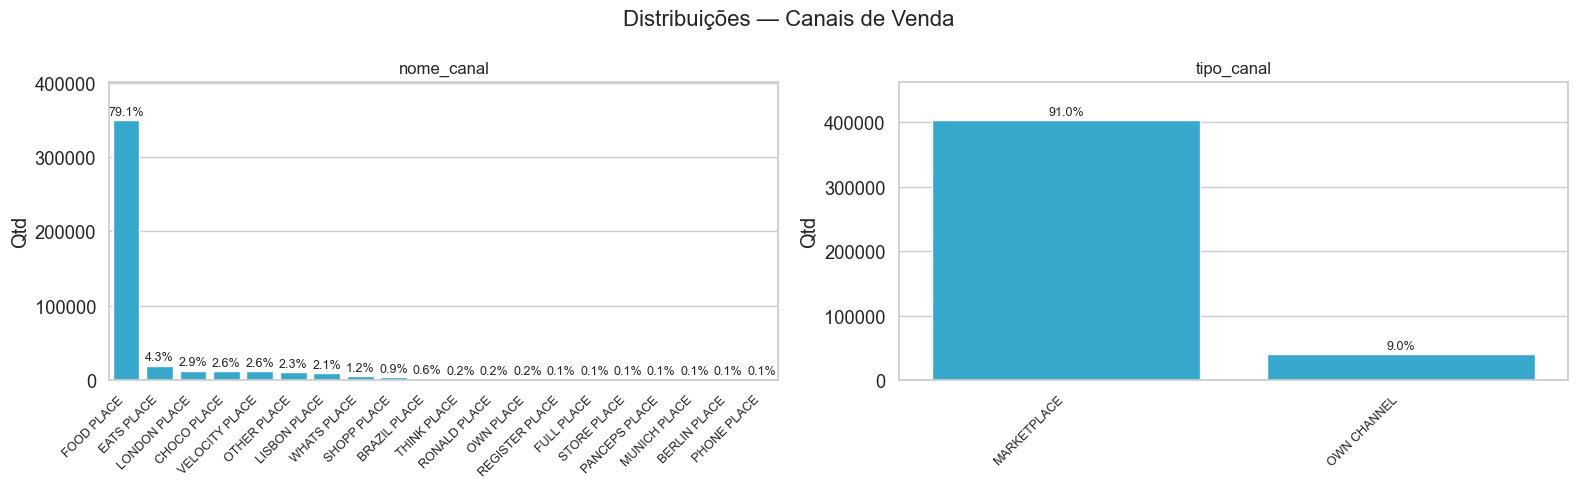

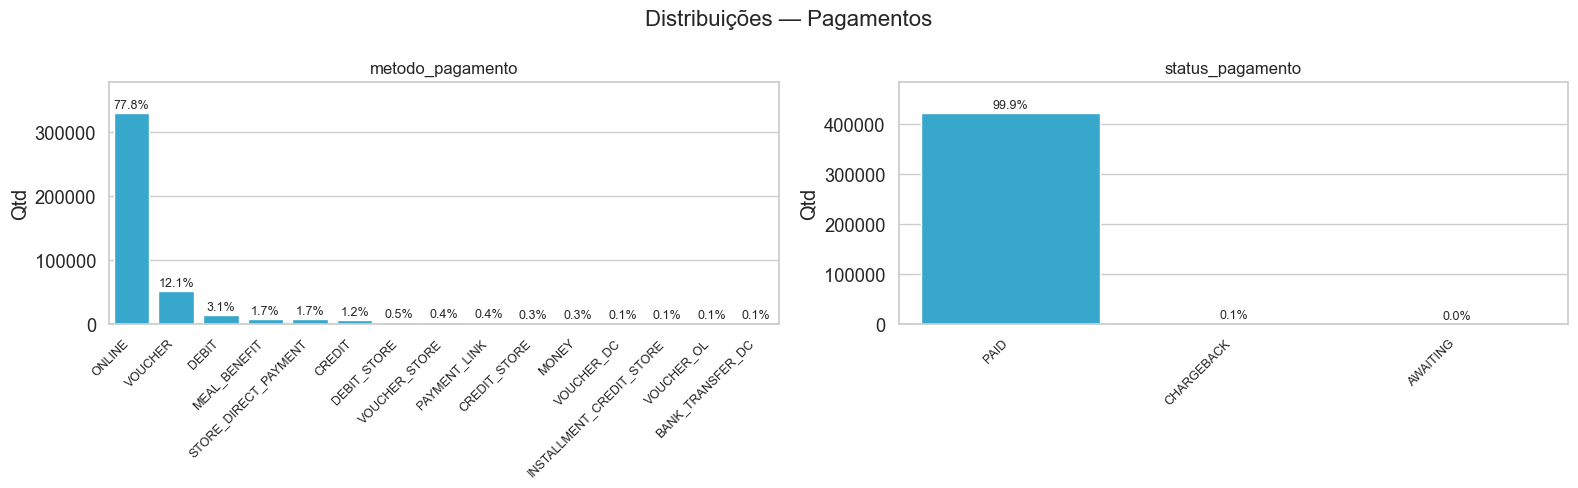

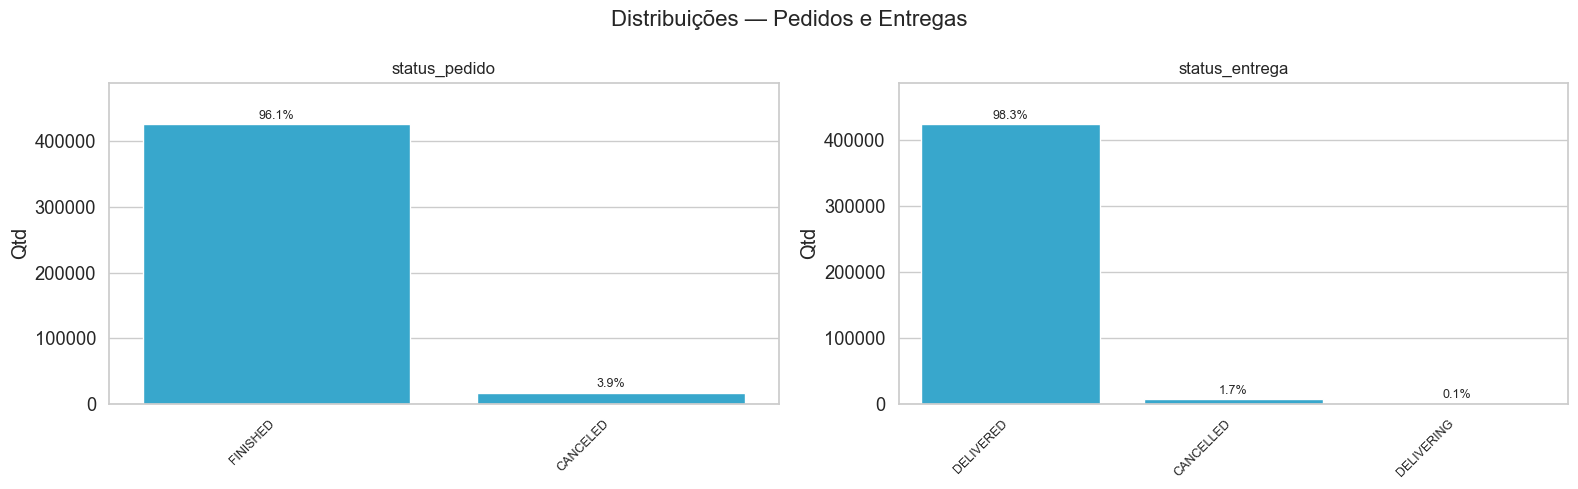

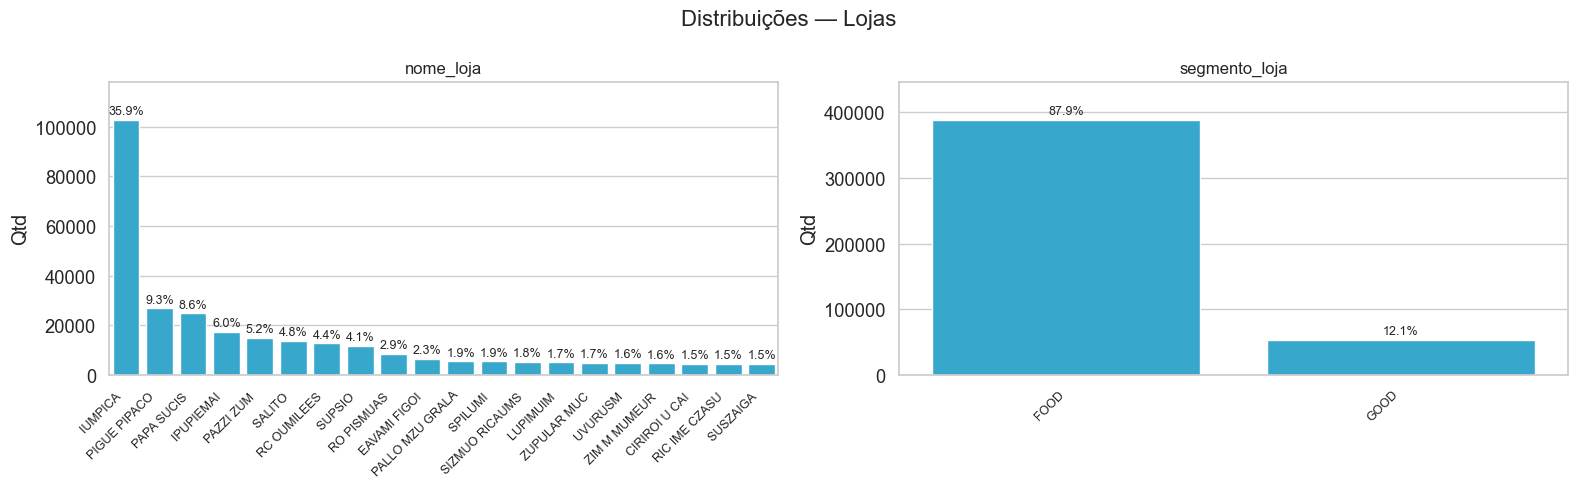

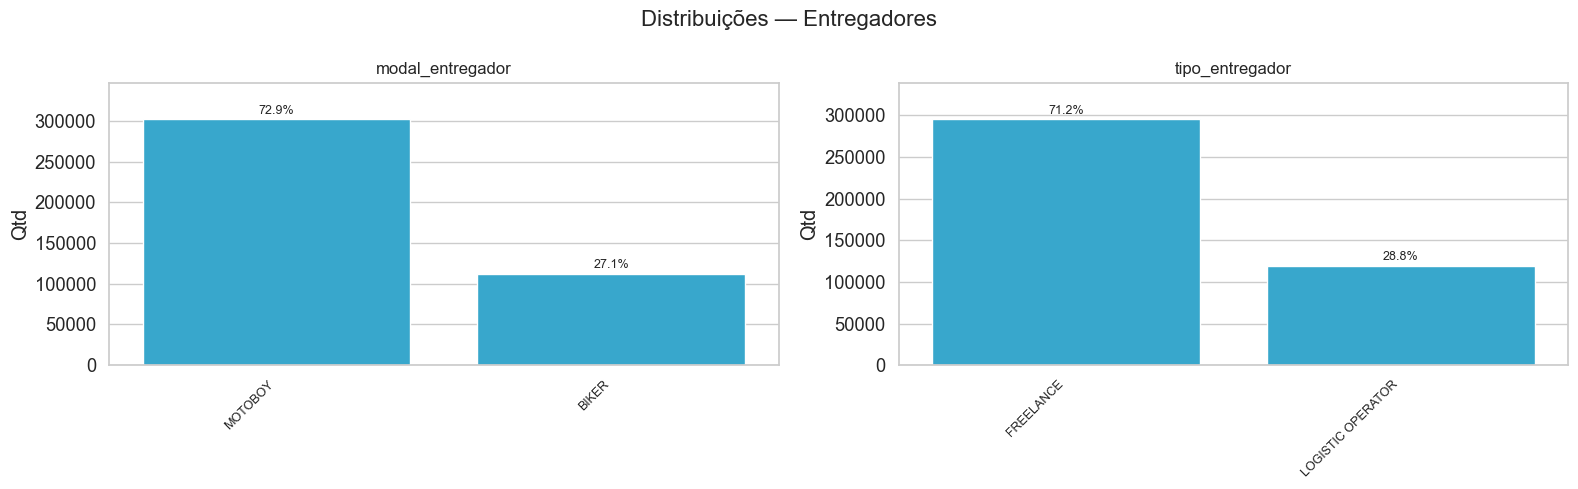

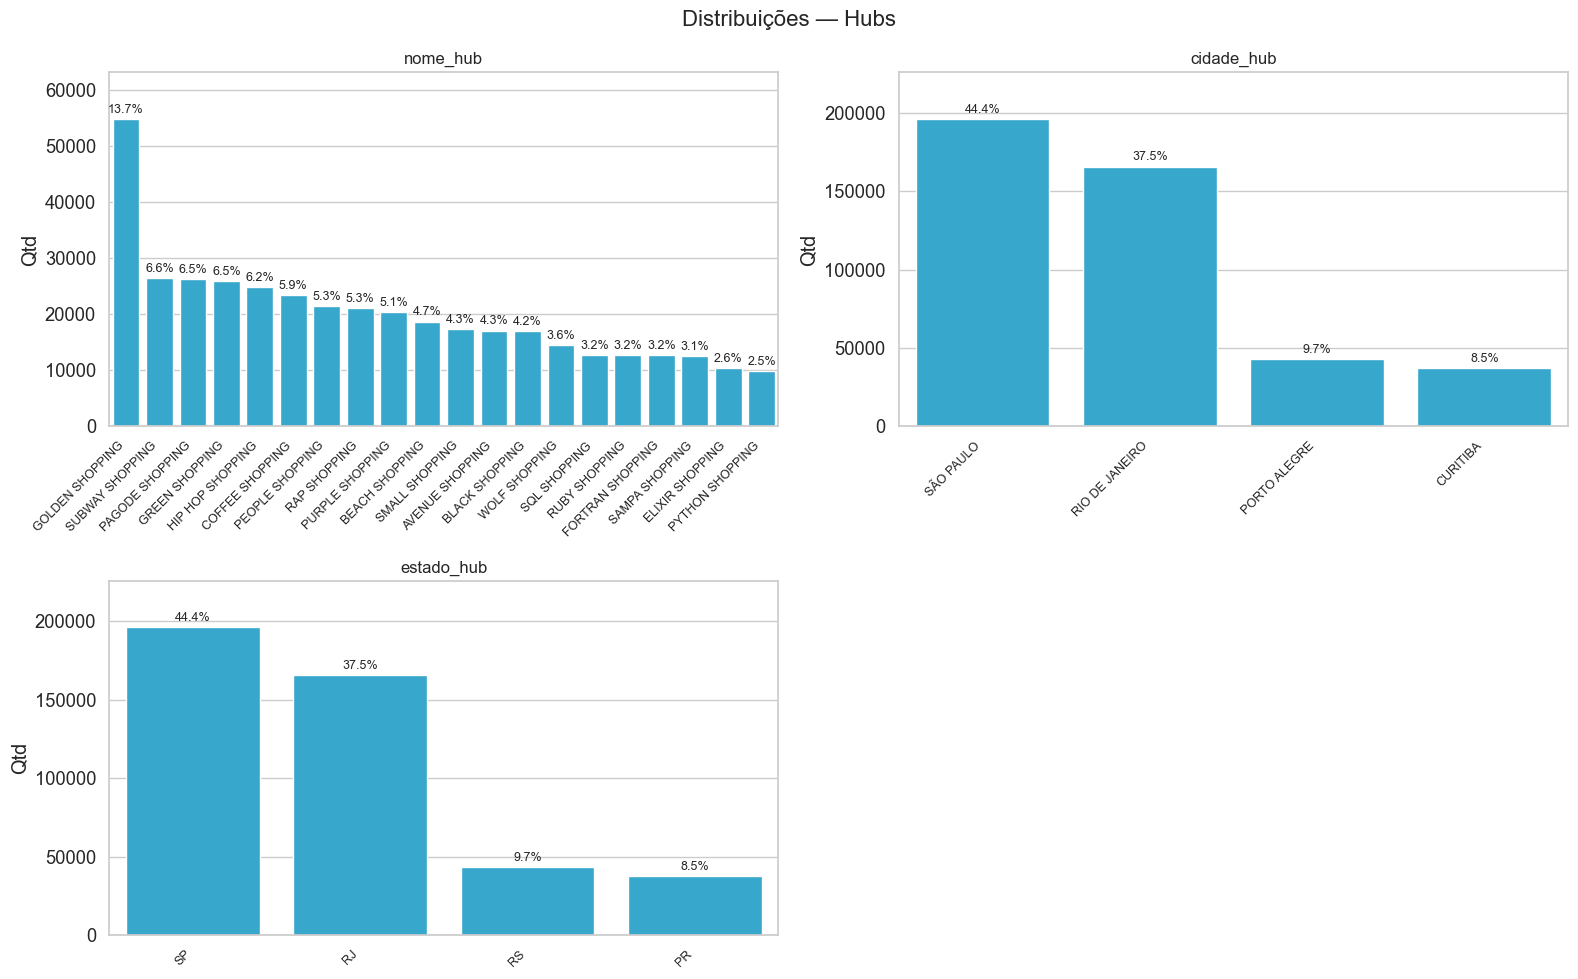

In [83]:
# Limites personalizados (mantido igual)
limites = {
    'nome_canal': 20,
    'nome_loja': 20,
    'nome_hub': 20,
}

# Loop adaptado
for grupo, variaveis in categoricas_grupos.items():
    # Se o grupo tiver mais de uma variável, usa subplots
    usar_subplot = len(variaveis) > 1

    plota_barras(
        variaveis=variaveis,
        df=df_full,
        titulo_base=f'Distribuições — {grupo}',
        rotation=45,
        limites=limites,
        usar_subplot=usar_subplot
    )


# <font color='green' style='font-size: 30px;'> 2.4) Análise de Variáveis Numéricas </font>
<hr style='border: 2px solid green;'>

> 1. As principais descobertas é que existem ruídos nos dados, sendo necessário tratar valores que sem dúvidas são erros nos dados na hora da modelagem

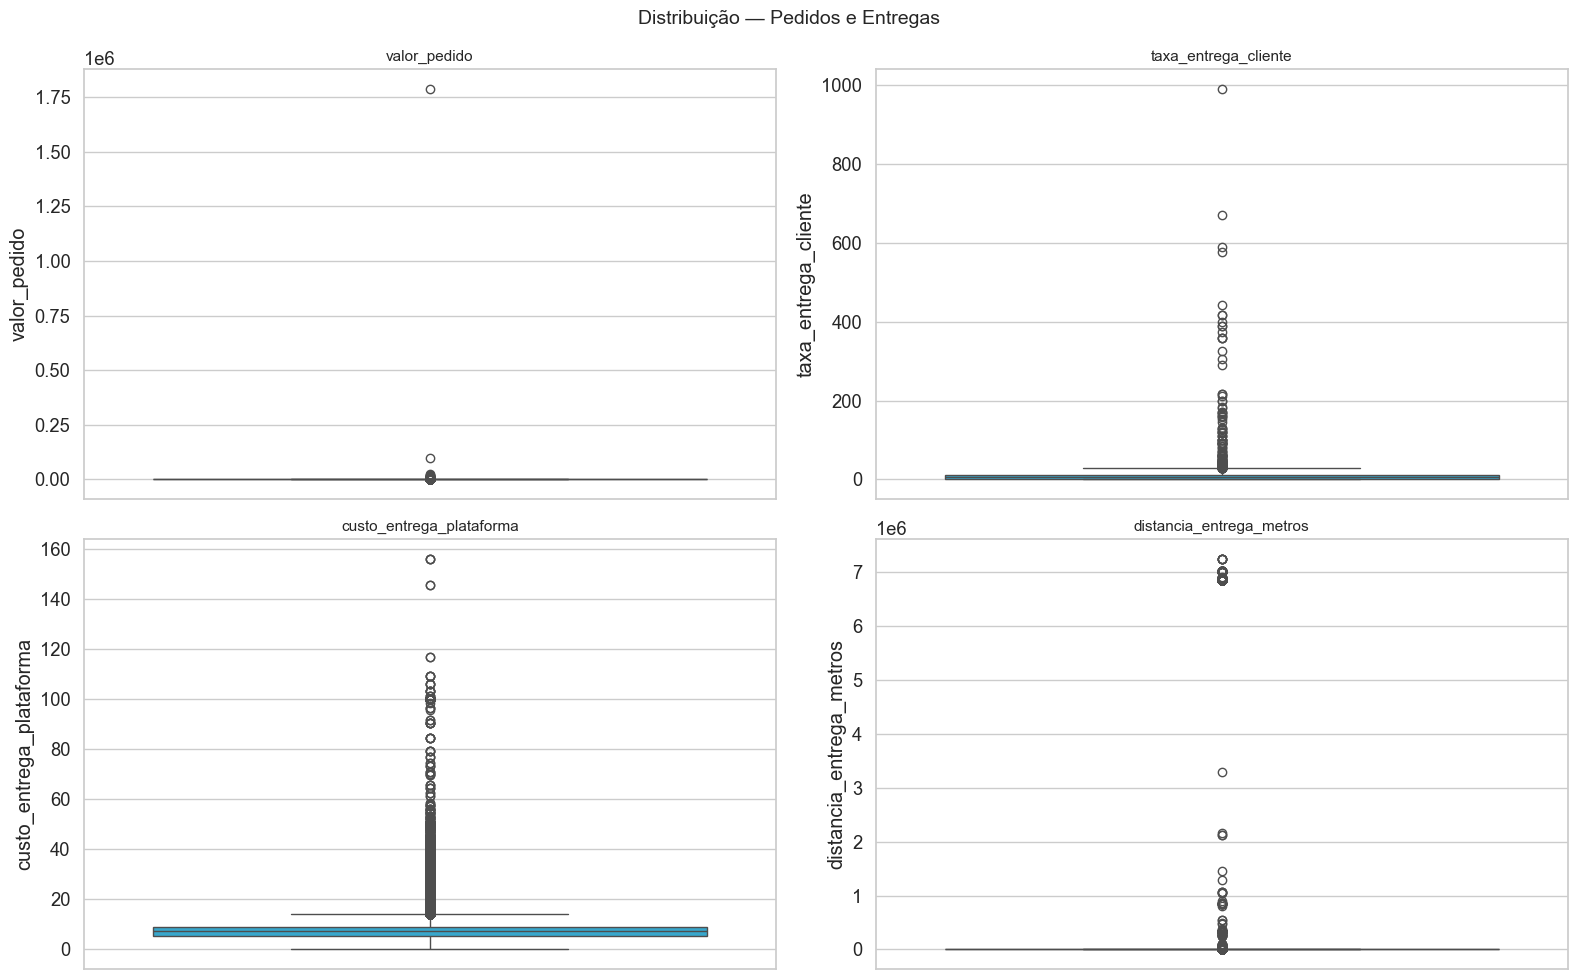

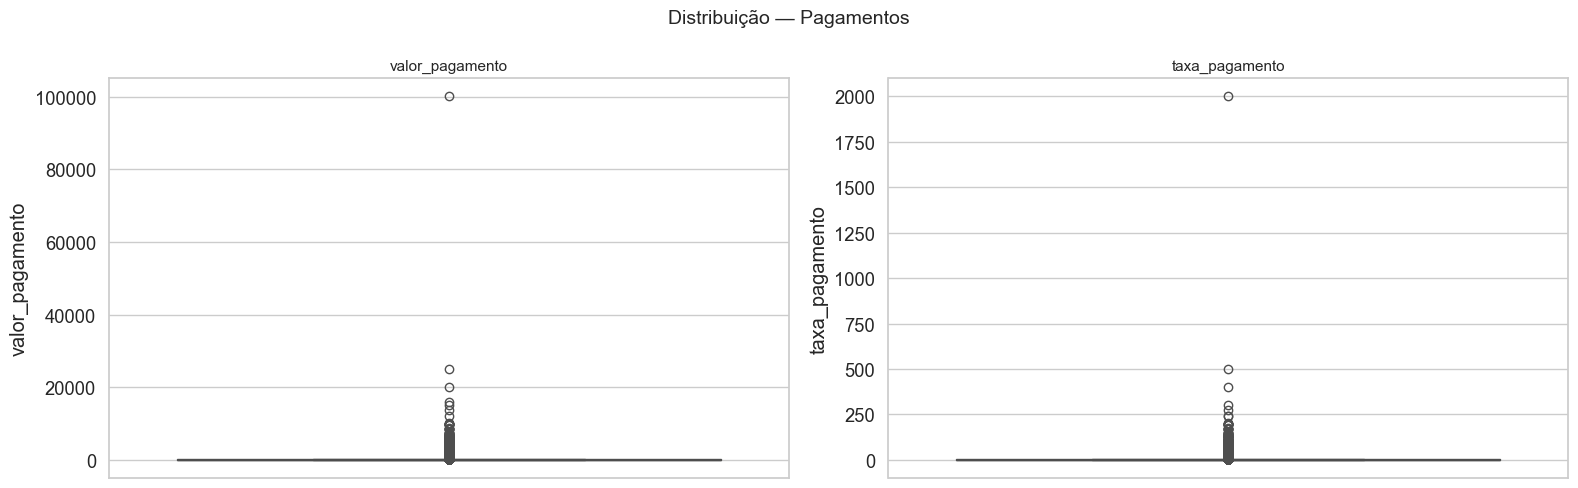

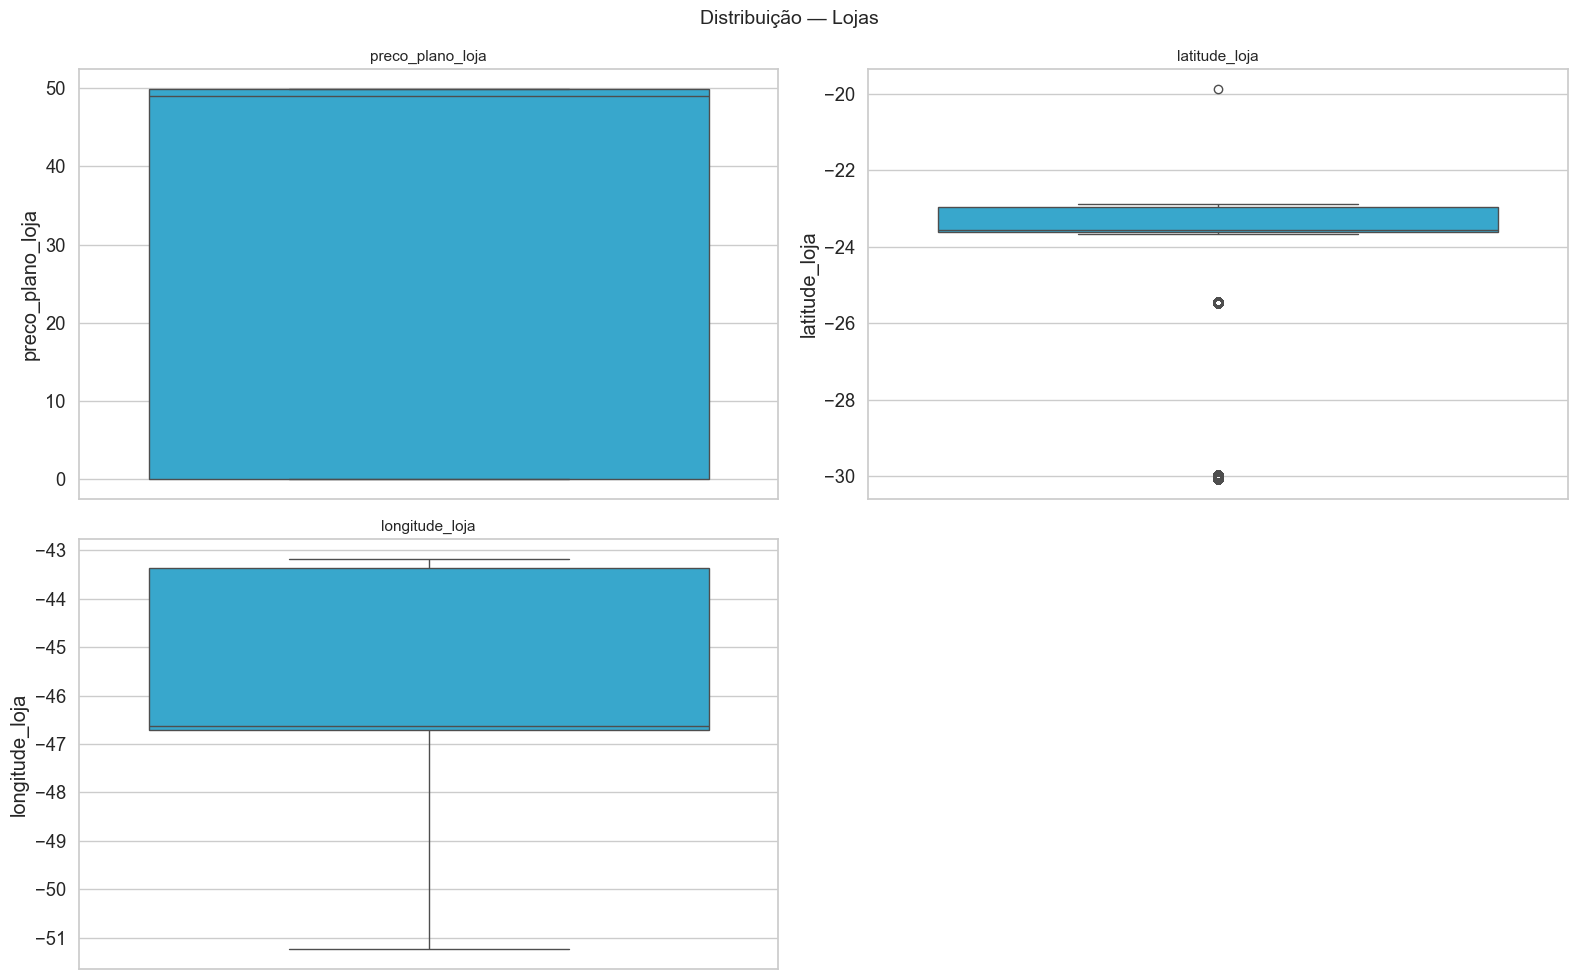

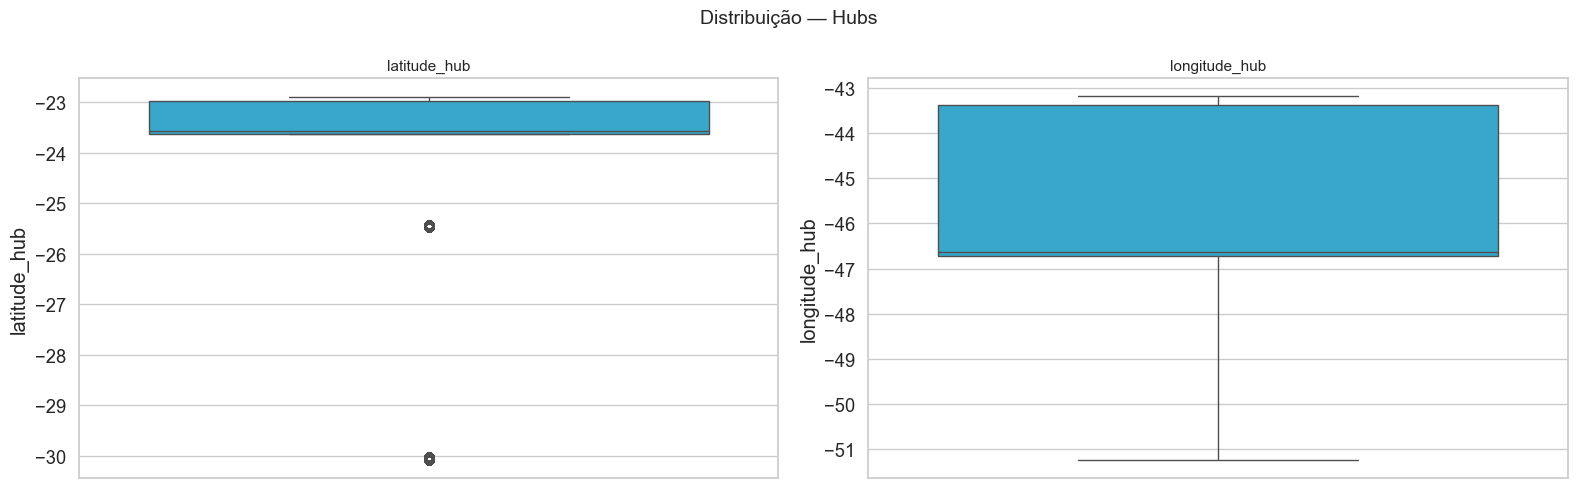

In [84]:
for grupo, variaveis in continuas_grupos.items():
    usar_subplot = len(variaveis) > 1
    plota_boxplot(
        df=df_full,
        variaveis=variaveis,
        titulo_base=f'Distribuição — {grupo}',
        usar_subplot=usar_subplot,
        modo='univariado'
    )


# <font color='green' style='font-size: 30px;'> 2.5) Análise de Variáveis Temporais </font>
<hr style='border: 2px solid green;'>

> 1. Em termos de Quantidade de Pedidos:

- Existem concentrações de pedidos aos finais de semana
- Os pedidos se intensificam a partir das 14h e das 20h, algo típico em cidades grandes
- Existe sazonalidade, bem como uma tendência de crescimento 
- Os pedidos durante os finais de semana costumam demorar um pouco mais
- Durante as horas mais movimentadas, os atrasos em pedidos ficam diferentes, mas isso pode ser causado pela quantidade de entregadores ou pelo tipo da entrega

In [85]:
# -----------------------
# 1) Conversão de datas
# -----------------------
tempos = [
    'momento_criacao_pedido', 'momento_aceite_pedido', 'momento_pedido_pronto',
    'momento_pedido_coletado', 'momento_pedido_expedicao', 'momento_pedido_em_entrega',
    'momento_pedido_entregue', 'momento_pedido_finalizado'
]

for col in tempos:
    df_full[col] = pd.to_datetime(df_full[col], errors='coerce')

# -----------------------
# 2) Criar coluna de data e dia da semana
# -----------------------
df_full["data_pedido"] = df_full["momento_criacao_pedido"].dt.date
df_full["dia_semana"] = df_full["momento_criacao_pedido"].dt.day_name()
df_full["hora_pedido"] = df_full["momento_criacao_pedido"].dt.hour

# -----------------------
# 3) Criar tempo entre aceite e finalização
# -----------------------
df_full["delta_pedido_aceite_finalizado"] = (
    df_full["momento_pedido_finalizado"] - df_full["momento_aceite_pedido"]
).dt.total_seconds() / 60

In [86]:
df_time_series = df_full.copy()
df_time_series["hora_pedido"] = df_time_series["hora_pedido"].astype(int)

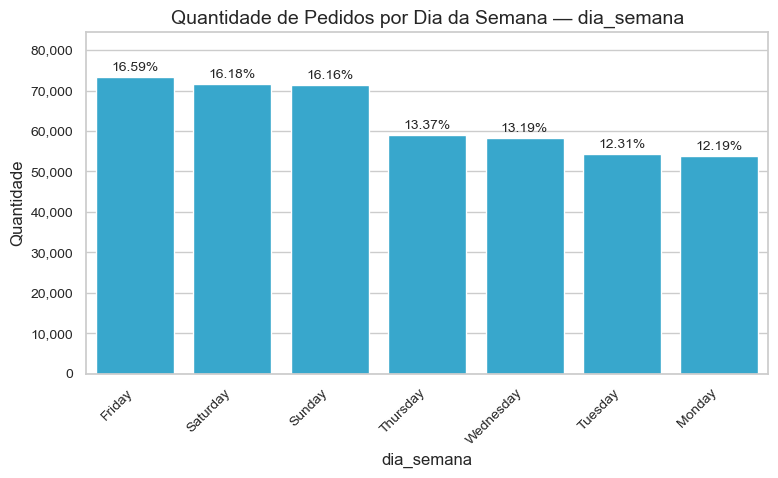

In [87]:
plota_barras(
    variaveis="dia_semana",
    df=df_time_series,
    titulo_base="Quantidade de Pedidos por Dia da Semana",
    rotation=45,
)

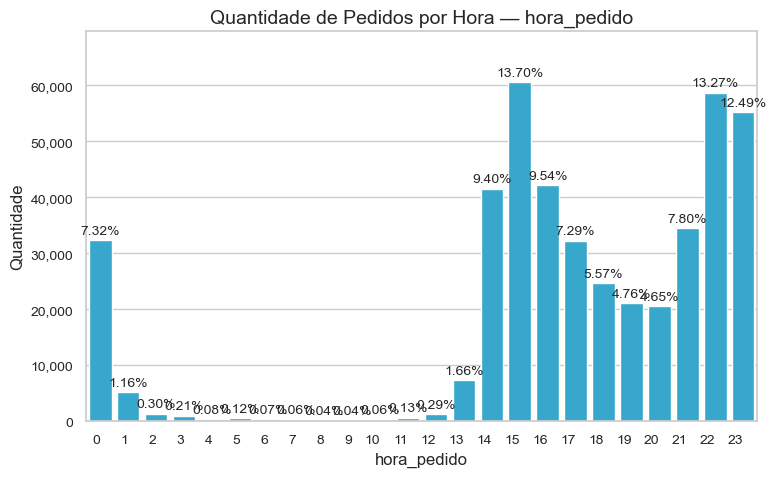

In [88]:
plota_barras(
    variaveis="hora_pedido",
    df=df_full,
    titulo_base="Quantidade de Pedidos por Hora",
    rotation=0
)


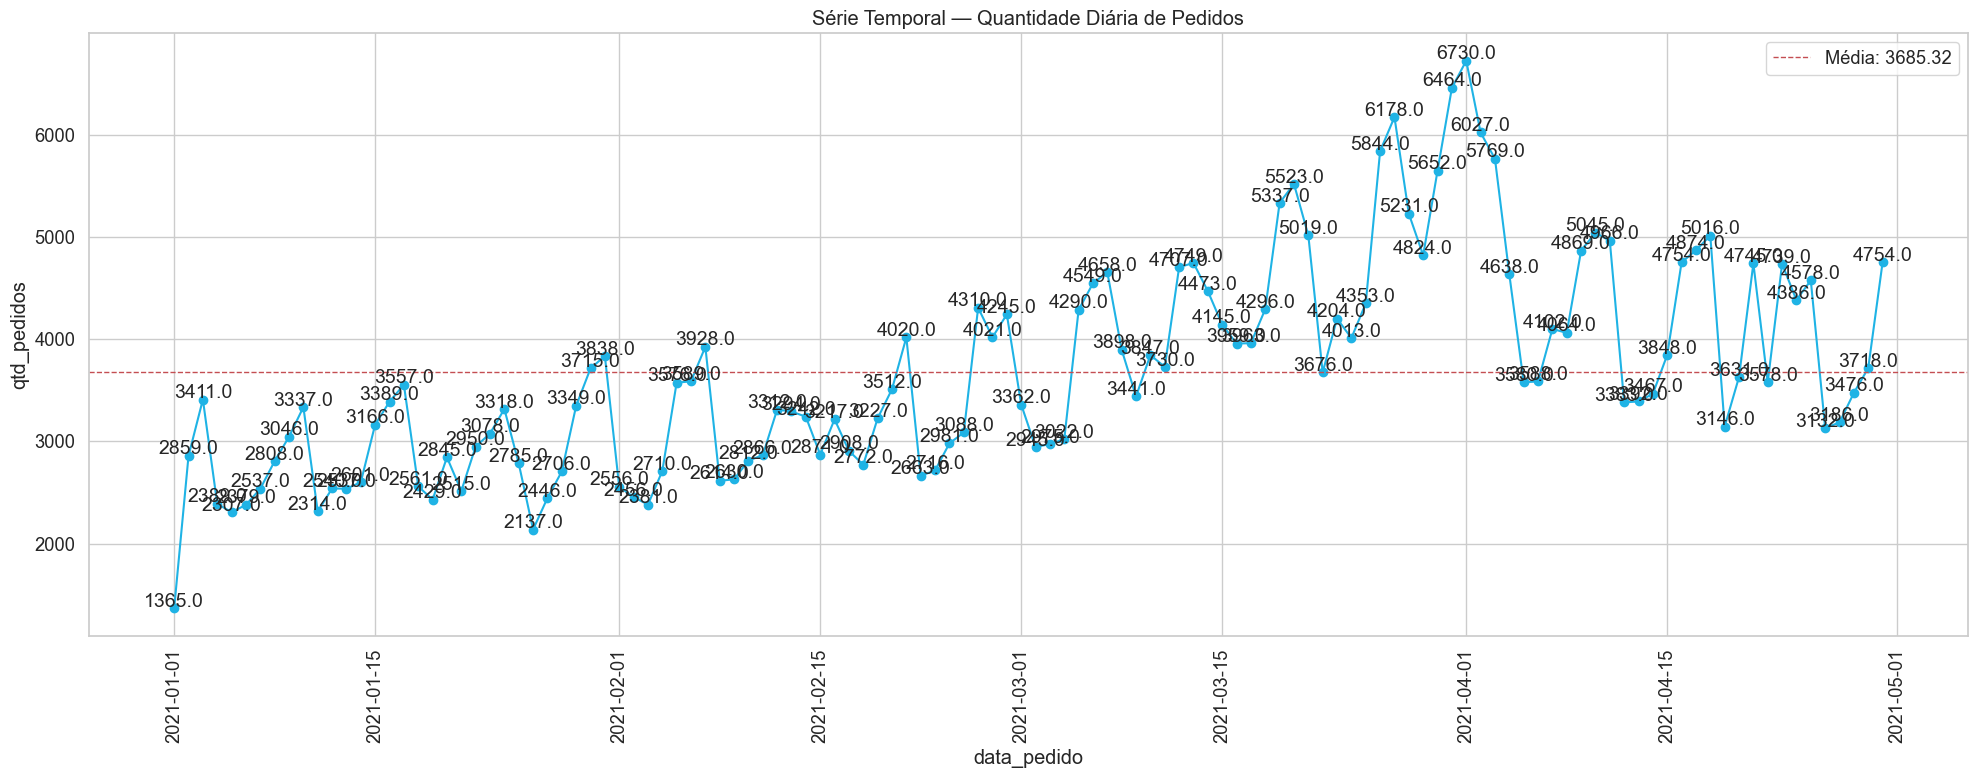

In [89]:
df_series = (
    df_full.groupby("data_pedido")
          .size()
          .reset_index(name="qtd_pedidos")
)

plota_grafico_linhas(
    df=df_series,
    x="data_pedido",
    y="qtd_pedidos",
    nao_calcula_media=False,
    title="Série Temporal — Quantidade Diária de Pedidos"
)


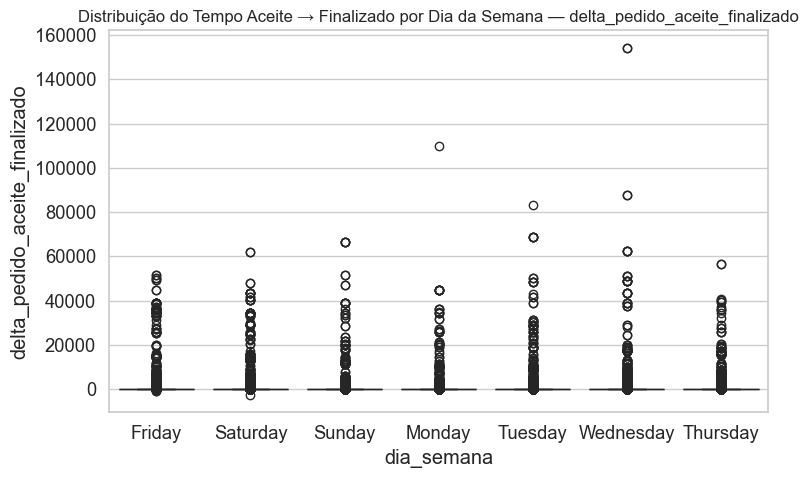

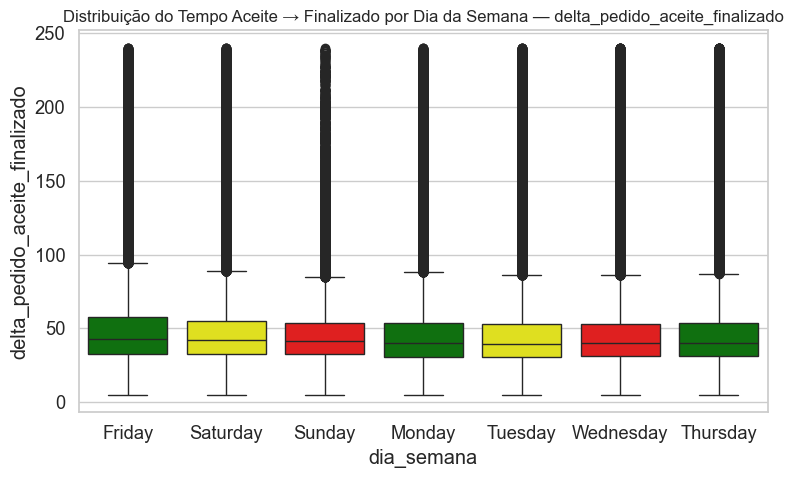

In [95]:
plota_boxplot(
    df=df_full,
    variaveis=["delta_pedido_aceite_finalizado"],
    target="dia_semana",
    titulo_base="Distribuição do Tempo Aceite → Finalizado por Dia da Semana",
    usar_subplot=False,
    modo="bivariado"
)

plota_boxplot(
    df=df_full.loc[df_full["delta_pedido_aceite_finalizado"].between(5, 240)],
    variaveis=["delta_pedido_aceite_finalizado"],
    target="dia_semana",
    titulo_base="Distribuição do Tempo Aceite → Finalizado por Dia da Semana",
    usar_subplot=False,
    modo="bivariado"
)


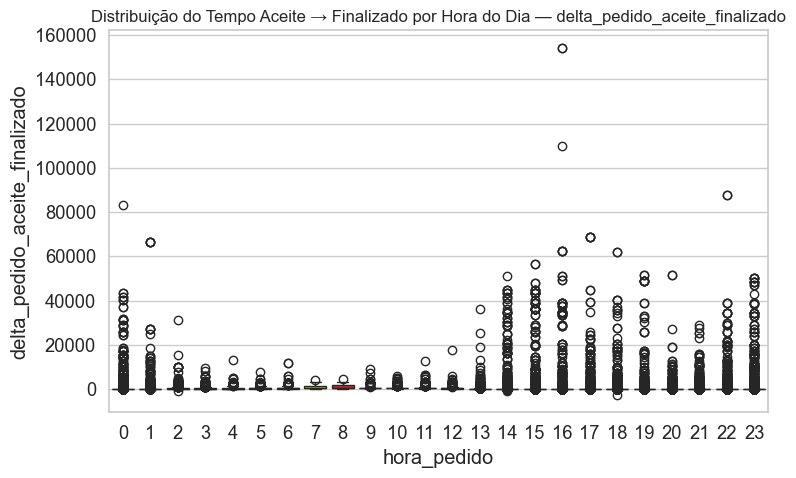

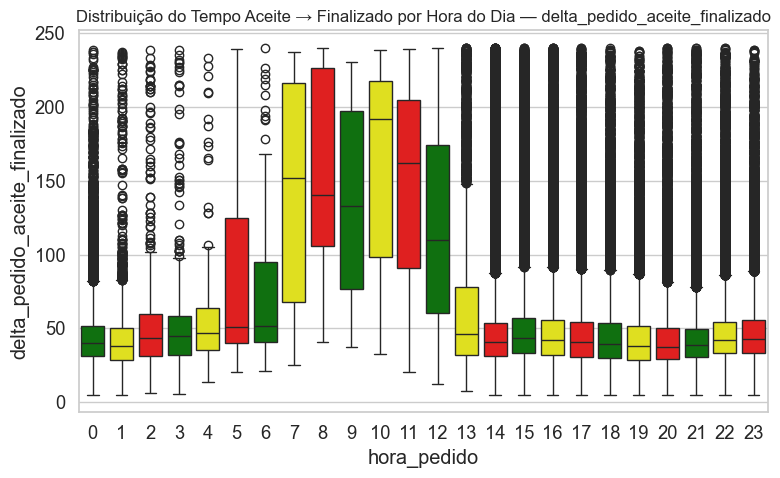

In [97]:
plota_boxplot(
    df=df_full,
    variaveis=["delta_pedido_aceite_finalizado"],
    target="hora_pedido",
    titulo_base="Distribuição do Tempo Aceite → Finalizado por Hora do Dia",
    usar_subplot=False,
    modo="bivariado"
)

plota_boxplot(
    df=df_full.loc[df_full["delta_pedido_aceite_finalizado"].between(5, 240)],
    variaveis=["delta_pedido_aceite_finalizado"],
    target="hora_pedido",
    titulo_base="Distribuição do Tempo Aceite → Finalizado por Hora do Dia",
    usar_subplot=False,
    modo="bivariado"
)
